<a href="https://colab.research.google.com/github/Orca934/100-ILSin1000Days-website/blob/main/Psychiatric_Text_Detection_And_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("szegeelim/mental-health")

print("Path to dataset files:", path)

100%|██████████| 11.1M/11.1M [00:00<00:00, 98.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/szegeelim/mental-health/versions/1


In [8]:
!ls {path}

'Combined Data.csv'


In [9]:
# general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# KNN
from sklearn.neighbors import KNeighborsClassifier

# scaling
from sklearn.preprocessing import StandardScaler

# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# training and testing
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

# pipline and cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Neural Network
from transformers import pipeline
from transformers import AutoTokenizer

In [27]:
pd.set_option("future.no_silent_downcasting",True)

In [28]:
df = pd.read_csv(f"{path}/Combined Data.csv")
df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [12]:
df.isnull().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [13]:
df.dropna(inplace=True)

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [16]:
df['status'] = df['status'].str.strip().str.lower()
df['status'] = df['status'].replace({'anxiety': 'anxiety_depression', 'depression': 'anxiety_depression', 'stress': 'anxiety_depression'})


In [17]:
df['status'].unique()

array(['anxiety_depression', 'normal', 'suicidal', 'bipolar',
       'personality disorder'], dtype=object)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  52681 non-null  int64 
 1   statement   52681 non-null  object
 2   status      52681 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [29]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [30]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [31]:
def drop_personality_disorder_status(df):
    return df[df['status'].str.strip().str.lower() != 'personality disorder']
df  = drop_personality_disorder_status(df)

In [22]:
df.groupby('status').count()

,statement
status,
anxiety_depression,21832
bipolar,2777
normal,16343
suicidal,10652


In [32]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [270]:
# prompt: undersample everything according to status untill its all 2587 tags for every unique value

def undersample_by_status(df, target_count=3500):
    undersampled_dfs = []
    for status in df['status'].unique():
        status_df = df[df['status'] == status]
        if len(status_df) > target_count:
            undersampled_dfs.append(status_df.sample(n=target_count, random_state=42))
        else:
            undersampled_dfs.append(status_df)
    return pd.concat(undersampled_dfs)

df = undersample_by_status(df)
df.groupby('status').count()


,statement,status_anxiety_depression,status_bipolar,status_normal,status_suicidal
status,,,,,
anxiety_depression,3500,3500,3500,3500,3500
bipolar,2777,2777,2777,2777,2777
normal,3500,3500,3500,3500,3500
suicidal,3500,3500,3500,3500,3500


In [271]:
# NEURAL NETWORK DO NOT RUN WITHOUT GPU OPTION SET!!!


# Load the GoEmotions model with truncation
emotion_classifier = pipeline(
    "text-classification",
    model="monologg/bert-base-cased-goemotions-original",
    top_k=None,
    device=0,           # Set to -1 if using CPU
    truncation=True     # Important to avoid token length issues
)

def add_deep_emotion_analysis(df, text_column='statement'):
    # Get the text data
    texts = df[text_column].tolist()

    # Get emotion scores in batch
    emotion_scores = emotion_classifier(texts)

    # Define relevant emotions (excluding surprise and approval, per your earlier request)
    emotion_columns = [
        'joy', 'sadness', 'anger', 'fear', 'disgust', 'neutral',
        'annoyance', 'confusion', 'desire', 'disappointment',
        'disapproval', 'nervousness', 'realization',
        'grief', 'embarrassment','love'
    ]

    # Prepare empty lists to store scores
    emotion_data = {col: [] for col in emotion_columns}

    # Populate emotion data
    for row in emotion_scores:
        emotion_dict = {emotion['label'].lower(): emotion['score'] for emotion in row}
        for emotion in emotion_columns:
            emotion_data[emotion].append(emotion_dict.get(emotion, 0.0))

    # Add scores as new columns in the DataFrame
    for emotion, scores in emotion_data.items():
        df[f'{emotion} score'] = scores
add_deep_emotion_analysis(df)

Device set to use cuda:0


In [272]:
df

,statement,status,status_anxiety_depression,status_bipolar,status_normal,status_suicidal,joy score,sadness score,anger score,fear score,...,annoyance score,confusion score,desire score,disappointment score,disapproval score,nervousness score,realization score,grief score,embarrassment score,love score
33939,Dr.’s office blew up my phone about results of...,anxiety_depression,1,0,0,0,0.000061,0.002804,0.000145,0.002836,...,0.000147,0.005269,0.000077,0.000567,0.000089,0.005849,0.001552,0.000370,0.000246,0.000704
47774,I hate my life I have always been alone. No fr...,anxiety_depression,1,0,0,0,0.000516,0.003018,0.969699,0.000663,...,0.005029,0.000803,0.000098,0.005803,0.000388,0.000420,0.002971,0.001261,0.005746,0.000470
20664,"No followup, I just liked the wordplay. I have...",anxiety_depression,1,0,0,0,0.000098,0.000017,0.000045,0.000006,...,0.001872,0.000036,0.000030,0.000055,0.000061,0.000008,0.000567,0.000004,0.000005,0.000441
9199,Hey everyone! I have been going through a real...,anxiety_depression,1,0,0,0,0.000073,0.016031,0.000497,0.000087,...,0.000296,0.010505,0.000139,0.909423,0.000431,0.001717,0.006707,0.000790,0.000769,0.000125
49114,"I’m at a loss. Hi, I’m a 23 year old mom of 3....",anxiety_depression,1,0,0,0,0.000809,0.001070,0.000200,0.992641,...,0.000040,0.000039,0.000135,0.000236,0.000133,0.001258,0.000322,0.000614,0.000096,0.000265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50649,"Head noise, intrusive thoughts, obsessive thin...",bipolar,0,1,0,0,0.003086,0.000096,0.001278,0.006877,...,0.024790,0.012101,0.001616,0.001187,0.007009,0.003510,0.074274,0.000466,0.096956,0.049512
50650,recently diagnosed &amp; very anxious when it ...,bipolar,0,1,0,0,0.000770,0.000098,0.000300,0.965391,...,0.000126,0.001241,0.000115,0.000196,0.000406,0.017215,0.000444,0.000180,0.000369,0.000729
50651,Puss in Boots: The Last Wish is the best repre...,bipolar,0,1,0,0,0.000233,0.001020,0.000400,0.296946,...,0.001765,0.006595,0.001284,0.003130,0.000447,0.065881,0.020130,0.000523,0.001861,0.002067
50652,Stable for years Hey everyone\n\nthanks for ta...,bipolar,0,1,0,0,0.000030,0.000040,0.000056,0.000030,...,0.000174,0.011968,0.000022,0.000056,0.000039,0.000026,0.000087,0.000024,0.000067,0.000048


In [273]:
df.corr(numeric_only=True)

,status_anxiety_depression,status_bipolar,status_normal,status_suicidal,joy score,sadness score,anger score,fear score,disgust score,neutral score,annoyance score,confusion score,desire score,disappointment score,disapproval score,nervousness score,realization score,grief score,embarrassment score,love score
status_anxiety_depression,1.000000,-0.307698,-0.357983,-0.357983,-0.012412,0.056517,-0.009787,0.101032,0.000586,-0.170759,0.014873,-0.001101,-0.013241,0.098329,-0.025303,0.195686,0.027846,0.000508,0.015094,-0.011970
status_bipolar,-0.307698,1.000000,-0.307698,-0.307698,-0.007037,-0.080319,-0.083739,0.048311,-0.024349,-0.188518,-0.030062,0.092922,-0.055619,-0.050934,-0.052283,0.043235,0.100387,-0.002531,0.046122,0.017632
status_normal,-0.357983,-0.307698,1.000000,-0.357983,0.025912,-0.152156,-0.127108,-0.186816,-0.043187,0.535580,-0.011892,-0.062933,-0.007490,-0.125351,0.057572,-0.142318,-0.100576,-0.170676,-0.059211,-0.006488
status_suicidal,-0.357983,-0.307698,-0.357983,1.000000,-0.007004,0.169781,0.214193,0.041189,0.065077,-0.190800,0.024769,-0.021742,0.072072,0.074040,0.015993,-0.093278,-0.019936,0.172504,0.001542,0.002182
joy score,-0.012412,-0.007037,0.025912,-0.007004,1.000000,-0.032287,-0.026655,-0.037830,-0.011028,-0.052773,-0.021008,-0.030065,-0.006375,-0.027636,-0.012349,-0.027029,-0.015214,0.054425,-0.012182,-0.001021
sadness score,0.056517,-0.080319,-0.152156,0.169781,-0.032287,1.000000,-0.061827,-0.114365,-0.031248,-0.169849,-0.072631,-0.092624,-0.037070,0.001735,-0.045704,-0.070649,-0.085529,0.254359,-0.041956,-0.043822
anger score,-0.009787,-0.083739,-0.127108,0.214193,-0.026655,-0.061827,1.000000,-0.078746,0.018163,-0.122064,0.027197,-0.066211,-0.028099,-0.052861,-0.021463,-0.065194,-0.067240,0.056648,-0.016128,-0.028118
fear score,0.101032,0.048311,-0.186816,0.041189,-0.037830,-0.114365,-0.078746,1.000000,-0.031639,-0.155210,-0.068390,-0.070853,-0.051620,-0.115826,-0.044814,0.026420,-0.090476,-0.007186,-0.035914,-0.052815
disgust score,0.000586,-0.024349,-0.043187,0.065077,-0.011028,-0.031248,0.018163,-0.031639,1.000000,-0.057405,-0.000052,-0.031605,-0.021242,-0.028730,-0.003564,-0.029048,-0.025869,0.044454,0.009611,-0.017400
neutral score,-0.170759,-0.188518,0.535580,-0.190800,-0.052773,-0.169849,-0.122064,-0.155210,-0.057405,1.000000,-0.085577,-0.102629,-0.064923,-0.150497,-0.049231,-0.117287,-0.125951,-0.143468,-0.067085,-0.077241


In [1]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

NameError: name 'plt' is not defined

In [131]:

#or
df['status'].eq('normal').sum() #alternative way to count occurrences of "normal"

np.int64(0)

<Axes: >

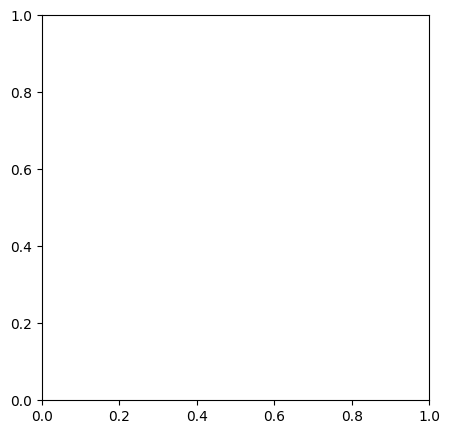

In [132]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df[df['status'] == 'normal'], x='joy score', y='neutral score', hue='status')

In [166]:
X = df.drop(columns=['status','statement','love score','desire score','annoyance score','embarrassment score'])
y = df['status']

X.shape, y.shape

((7000, 14), (7000,))

In [167]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [168]:
pipe = Pipeline([
('scale', StandardScaler()),
('knn', KNeighborsClassifier())
                 ])

In [169]:
param_grid = {
    'knn__n_neighbors' : [k for k in range (1,50,10)]

}
param_grid

{'knn__n_neighbors': [1, 11, 21, 31, 41]}

In [170]:
knn_clf = GridSearchCV(pipe, param_grid, cv=5, verbose = 1)
knn_clf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 11, 21, 31, 41]}, verbose=1)

In [171]:
cv_results = pd.DataFrame(knn_clf.cv_results_)
cv_results[['param_knn__n_neighbors', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')

,param_knn__n_neighbors,mean_test_score,rank_test_score
2,21,0.812500,1
4,41,0.812143,2
1,11,0.810357,3
3,31,0.807679,4
0,1,0.761786,5


In [139]:
df['status'].unique()

array([1, 0])

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


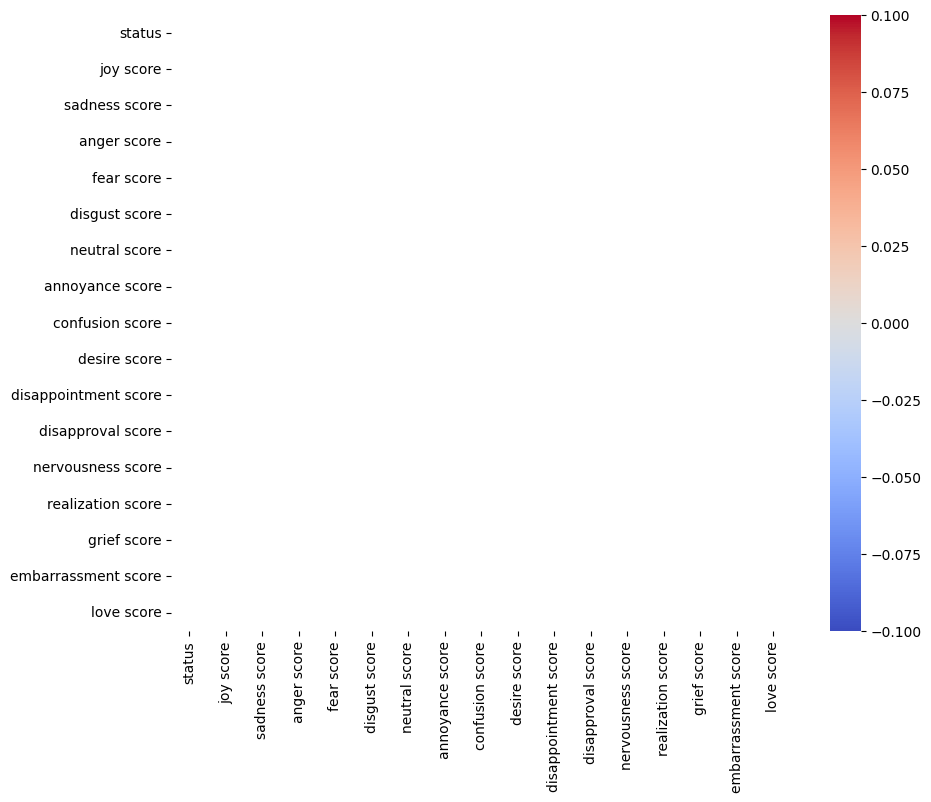

In [141]:
# prompt: make a correlation heatmap where the only values show are the Normal tag

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame from the previous code
plt.figure(figsize=(10, 8))
sns.heatmap(df[df['status'] == 'anxiety_depression'].corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()
